In [15]:
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm

In [16]:
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
from typing import NamedTuple, Optional, Tuple, Generator

import numpy as np
from matplotlib import pyplot as plt
# from skimage.draw import circle_perimeter_aa


class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int


def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(
        img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()


def generate_examples(
        noise_level: float = 0.5,
        img_size: int = 100,
        min_radius: Optional[int] = None,
        max_radius: Optional[int] = None,
        dataset_path: str = 'ds',
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params


def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        # If the distance between the centers is greater than the sum of the radii, then the circles don't intersect
        return 0.0
    if d <= abs(r1 - r2):
        # If the distance between the centers is less than the absolute difference of the radii, then one circle is 
        # inside the other
        larger_r, smaller_r = max(r1, r2), min(r1, r2)
        return smaller_r ** 2 / larger_r ** 2
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    sector_area1 = r1_sq * np.arccos(d1 / r1)
    triangle_area1 = d1 * np.sqrt(r1_sq - d1**2)
    sector_area2 = r2_sq * np.arccos(d2 / r2)
    triangle_area2 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = sector_area1 + sector_area2 - (triangle_area1 + triangle_area2)
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

def calculate_accuracy(predictions, targets, threshold=0.5):
    """
    Calculate accuracy based on Intersection over Union (IoU) for circle detection.
    :param predictions: List of predicted CircleParams.
    :param targets: List of target CircleParams.
    :param threshold: IoU threshold for considering a prediction correct.
    :return: Accuracy value.
    """
    correct_predictions = 0

    for pred, target in zip(predictions, targets):
        pred_circle = CircleParams(row=int(pred[0]), col=int(pred[1]), radius=int(pred[2]))
        target_circle = CircleParams(row=int(target[0]), col=int(target[1]), radius=int(target[2]))
        iou_value = iou(pred_circle, target_circle)
        if iou_value >= threshold:
            correct_predictions += 1

    accuracy = correct_predictions / len(predictions)
    return accuracy


In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Set parameters
noise_level = 0.1
img_size = 100
min_radius = img_size // 10
max_radius = img_size // 2

# Create a generator
data_generator = generate_examples(noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius)

# Generate train and test datasets
num_samples = 30000
train_data, test_data = train_test_split([next(data_generator) for _ in range(num_samples)], test_size=0.2)

# Access images and parameters
train_images, train_params = zip(*train_data)
test_images, test_params = zip(*test_data)

Using parameters: noise_level=0.1, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


In [19]:
X_train = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)
Y_train = torch.tensor(train_params, dtype=torch.float32)

X_test = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
Y_test = torch.tensor(test_params, dtype=torch.float32)

train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

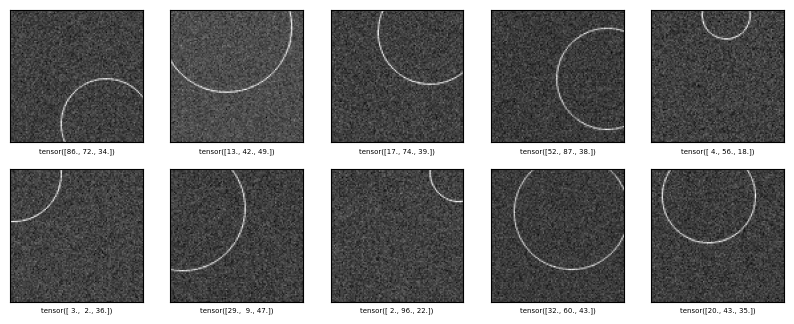

In [20]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].squeeze(), cmap="grey")
    plt.xlabel(Y_train[i], fontsize = 5)

plt.show()

### Prepare data for training and testing

In [21]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset= train_data, 
                          batch_size= BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset= test_data, 
                          batch_size= BATCH_SIZE,
                          shuffle=False)
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train data loader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test data loader: {len(test_loader)} batches of {BATCH_SIZE}")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7f194c20fd00>, <torch.utils.data.dataloader.DataLoader object at 0x7f194c20dcc0>)
Length of train data loader: 750 batches of 32
Length of test data loader: 188 batches of 32


In [22]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 100, 100]), torch.Size([32, 3]))

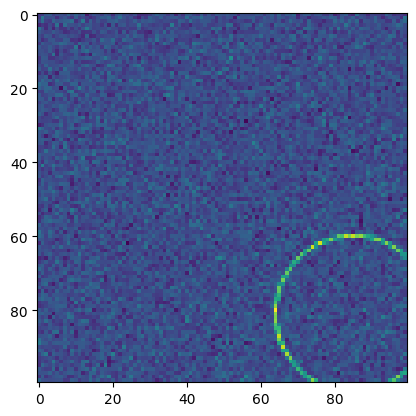

In [23]:

plt.imshow(train_features_batch[0].squeeze())

In [24]:
from timeit import default_timer as timer 
def print_train_time(start: float,
                     end: float, 
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [25]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device= device):
    train_loss, train_acc = 0, 0
    model.train()


    # Loop through training batches
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss # accumulate train loss
        train_acc += calculate_accuracy(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader) #(average loss per batch)
    train_acc /= len(data_loader)

    print(f"Train Loss: {train_loss: .5f} | Train Accuracy: {train_acc:.2f}")
    return (train_loss, train_acc)

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               calculate_accuracy,
               device: torch.device= device):

    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)

            test_acc += calculate_accuracy(predictions=test_pred, targets=y_test)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test Loss: {test_loss: .5f} | Test Accuracy: {test_acc:.2f}")
        return (test_loss, test_acc)

In [26]:
torch.manual_seed(42)
def eval_model(model, 
               data_loader,
               loss_fn,
               calculate_accuracy):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += calculate_accuracy(predictions=test_pred, targets=y_test)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}


In [27]:
import torch.nn.functional as F
from torch import nn


class CNNModel(nn.Module):
    def __init__(self, input_shape=1, hidden_units=64, output_shape=3, img_size=100):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), # [1, 64]
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1), #[64, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),#[128, 256]
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),#[256, 256]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*25*25, out_features=hidden_units*4*25*25*4)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*4*25*25*4, out_features=hidden_units*4*25*25),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*4*25*25*4, out_features=output_shape)

        )

    def forward(self, x):
        x = self.conv_block1(x)
        print(x.shape)
        x = self.conv_block2(x)
        print(x.shape)
        x = self.out_layer(x)
        print(x.shape)
        return x

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2028743229.py, line 24)

In [28]:
model = CNNModel().to(device=device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0001)

torch.manual_seed(42)
start_time= timer()

epochs = 100
train_losses = []
test_losses = []
test_accs = []
epochs_ = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_loss, train_acc = train_step(model = model,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    test_loss, test_acc = test_step(model = model,
               data_loader=test_loader,
               loss_fn=loss_fn,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    epochs_.append(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)





    # Calculate training time
    end_time = timer()
    total_train_time_model = print_train_time(start=start_time,
                                                end=end_time,
                                                device=str(next(model.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
--------


OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB. GPU 0 has a total capacty of 44.40 GiB of which 53.31 MiB is free. Process 1304403 has 14.01 GiB memory in use. Process 3490174 has 14.09 GiB memory in use. Process 3687544 has 14.03 GiB memory in use. Including non-PyTorch memory, this process has 2.04 GiB memory in use. Of the allocated memory 618.57 MiB is allocated by PyTorch, and 121.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF